# Module 4.4. Adding files


### Exercise overview

In this exercise, you'll learn how to use data copying and using files



## Step 1: Setup your notebook

### Select Lakehouse

First, add the Lakehouse you created from the prior lab exercise.



## Step 2: Install and import required libraries

Before we move forward with sentiment analysis of customer reviews, it is imperative to first install and import the essential libraries from Spark and SynapseML.

In [ ]:
%pip install wordcloud textblob

In [5]:
import os, requests, uuid

import synapse.ml.core
from synapse.ml.services.language import AnalyzeText

from pyspark.sql.functions import explode, split, col
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from textblob import TextBlob

StatementMeta(, 0cc438d3-1b77-4fb5-988c-10cb362cd0f2, 28, Finished, Available, Finished)

## Step 3: Load and explore the data

In [6]:
IS_CUSTOM_DATA = False  # if TRUE, dataset has to be uploaded manually

DATA_FOLDER = "Files/customer_feedback"  # folder with data files
DATA_FILE = "customer_feedback.csv"  # data file name

StatementMeta(, 0cc438d3-1b77-4fb5-988c-10cb362cd0f2, 29, Finished, Available, Finished)

In [7]:
if not IS_CUSTOM_DATA:

    import os, requests
    # Download demo data files into lakehouse if not exist
    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/LLM-Demo"
    fname = "customer_feedback.csv"
    download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError("Default lakehouse not found, please add a lakehouse and restart the session.")
    os.makedirs(download_path, exist_ok=True)
    if not os.path.exists(f"{download_path}/{fname}"):
        r = requests.get(f"{remote_url}/{fname}", timeout=30)
        with open(f"{download_path}/{fname}", "wb") as f:
            f.write(r.content)
    print("Downloaded demo data files into lakehouse.")

StatementMeta(, 0cc438d3-1b77-4fb5-988c-10cb362cd0f2, 30, Finished, Available, Finished)

Downloaded demo data files into lakehouse.


In [8]:
df_spark = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", True)
    .load(f"{DATA_FOLDER}/raw/{DATA_FILE}")
    .cache()
)

StatementMeta(, 0cc438d3-1b77-4fb5-988c-10cb362cd0f2, 31, Finished, Available, Finished)

In [9]:
display(df_spark)

StatementMeta(, 0cc438d3-1b77-4fb5-988c-10cb362cd0f2, 32, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 6600f88e-d85a-4311-852a-fa048322d764)

In [10]:
# List the columns of Spark DataFrame
df_spark.columns

StatementMeta(, 0cc438d3-1b77-4fb5-988c-10cb362cd0f2, 33, Finished, Available, Finished)

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited',
 'CustomerFeedback']

In [11]:
# Display DataFrame schema
df_spark.printSchema()

StatementMeta(, 0cc438d3-1b77-4fb5-988c-10cb362cd0f2, 34, Finished, Available, Finished)

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)
 |-- CustomerFeedback: string (nullable = true)



#### Word Cloud of most common words

The word cloud of most common words is a visualization technique illustrating the prevalent terms within a text dataset. Initially, the text undergoes preprocessing to remove irrelevant elements such as punctuation and stopwords.
Following this, the frequency of each word is calculated based on its occurrence in the dataset. These words are then visually represented in a cloud-like formation, where larger words indicate higher frequency.
This visualization offers a swift and intuitive insight into the primary themes or topics present in the text data.


StatementMeta(, 0cc438d3-1b77-4fb5-988c-10cb362cd0f2, 35, Finished, Available, Finished)

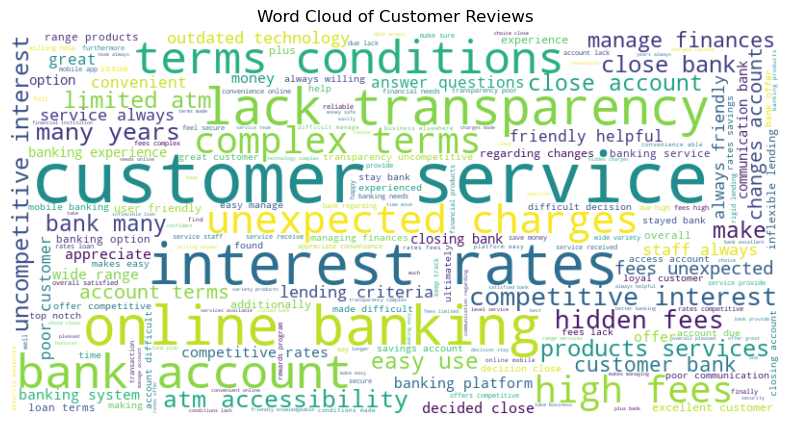

In [12]:
from pyspark.sql.functions import explode, split, col
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.ml.feature import StopWordsRemover

reviews_text = " ".join(review['CustomerFeedback'] for review in df_spark.select('CustomerFeedback').collect())

# Convert the reviews text to lowercase
reviews_text_lower = reviews_text.lower()
# Create a list of words
words = reviews_text_lower.split()
# Load English stopwords
stopwords = set(StopWordsRemover().getStopWords())
# Remove stopwords from the list of words
filtered_words = [word for word in words if word not in stopwords]
# Join the filtered words back into a single string
filtered_reviews_text = " ".join(filtered_words)
# Generate WordCloud with stopwords removed
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_reviews_text)

# Plot WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Customer Reviews')
plt.show()



#### Sentiment analysis pie chart 
A Sentiment Analysis Pie Chart is a visual representation of sentiment categories (such as positive, negative, and neutral) derived from analyzing text data. It displays the distribution of sentiments within the dataset, typically using a circular chart where each segment represents a sentiment category and its size reflects the proportion of text data assigned to that sentiment category.

StatementMeta(, 0cc438d3-1b77-4fb5-988c-10cb362cd0f2, 36, Finished, Available, Finished)

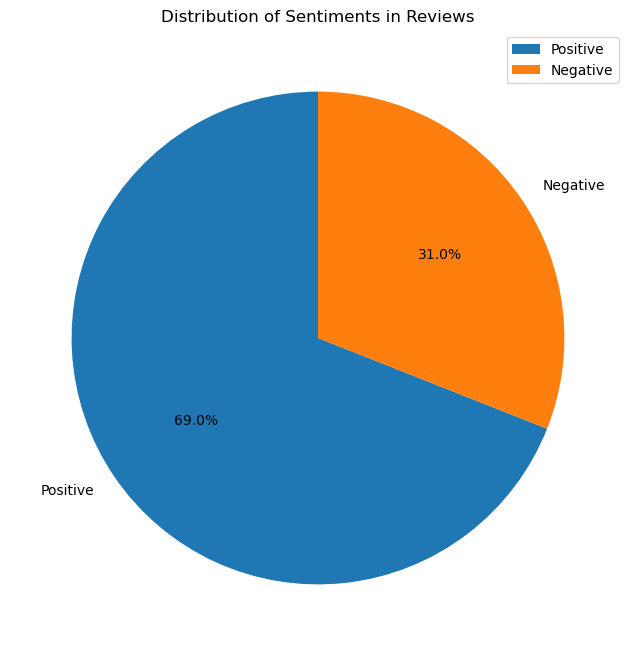

In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from textblob import TextBlob

# Define a UDF for sentiment analysis using TextBlob
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Register UDF
sentiment_udf = udf(get_sentiment, StringType())

# Apply sentiment analysis to each review
df_with_sentiment = df_spark.withColumn('sentiment', sentiment_udf('CustomerFeedback'))

# Calculate count of each sentiment category
sentiment_counts = df_with_sentiment.groupBy('sentiment').count()

# Convert to Pandas DataFrame for plotting
sentiment_counts_pd = sentiment_counts.toPandas()

# Plotting
sentiment_counts_pd.plot(kind='pie', y='count', labels=sentiment_counts_pd['sentiment'],
                         autopct='%1.1f%%', startangle=90, figsize=(8, 8))
plt.ylabel('')
plt.title('Distribution of Sentiments in Reviews')
plt.show()


In [18]:
# Perform sentiment analysis
df_sentiment_results = sentiment_analysis_model.transform(df_sample)
# Display the original feedback and the sentiment analysis
display(df_sentiment_results.select("CustomerFeedback", "sentiment_analysis.documents.sentiment"))

StatementMeta(, 0cc438d3-1b77-4fb5-988c-10cb362cd0f2, 41, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 6df08d33-9133-480f-b48e-57d1dac7c667)